In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
trials = 1000
stddev = 3
autocorr_fractional_error = np.zeros(trials, dtype=float)
crosscorr_fractional_error = np.zeros(trials, dtype=float)

for trial_ind in range(trials):

    # Define random Gaussian per-antenna signals
    antenna_values = np.random.normal(scale=stddev, size=(352)) + 1j * np.random.normal(
        scale=stddev, size=(352)
    )

    # Quantize values to integers [-7, 7]
    antenna_values_quantized_real_part = np.round(np.real(antenna_values))
    antenna_values_quantized_real_part[
        np.where(antenna_values_quantized_real_part < -7)
    ] = -7
    antenna_values_quantized_real_part[np.where(antenna_values_quantized_real_part > 7)] = 7
    antenna_values_quantized_imag_part = np.round(np.imag(antenna_values))
    antenna_values_quantized_imag_part[
        np.where(antenna_values_quantized_imag_part < -7)
    ] = -7
    antenna_values_quantized_imag_part[np.where(antenna_values_quantized_imag_part > 7)] = 7
    antenna_values_quantized = (
        antenna_values_quantized_real_part + 1j * antenna_values_quantized_imag_part
    )

    # Calculate autocorrelations
    autocorrs_orig = antenna_values * np.conj(antenna_values)
    autocorrs_quantized = antenna_values_quantized * np.conj(antenna_values_quantized)

    # Calculate cross correlations
    crosscorrs_orig = antenna_values[:, np.newaxis] * np.conj(
        antenna_values[np.newaxis, :]
    )
    crosscorrs_quantized = antenna_values_quantized[:, np.newaxis] * np.conj(
        antenna_values_quantized[np.newaxis, :]
    )
    # Mask autocorrelations and conjugated values
    crosscorrs_orig[np.tril_indices(352, k=1)] = np.nan
    crosscorrs_quantized[np.tril_indices(352, k=1)] = np.nan

    # Calculate fractional error
    autocorr_fractional_error[trial_ind] = np.nanmean(
        np.abs(autocorrs_orig - autocorrs_quantized) / np.abs(autocorrs_orig)
    )
    crosscorr_fractional_error[trial_ind] = np.nanmean(
        np.abs(crosscorrs_orig - crosscorrs_quantized) / np.abs(crosscorrs_orig)
    )

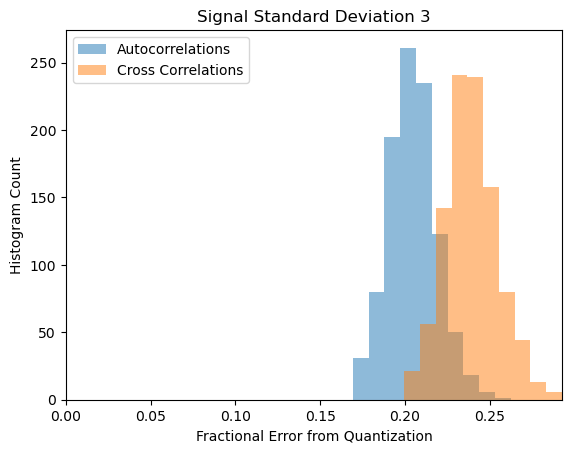

In [53]:
plt.hist(autocorr_fractional_error, alpha=.5, label="Autocorrelations")
plt.hist(crosscorr_fractional_error, alpha=0.5, label="Cross Correlations")
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.title(f"Signal Standard Deviation {stddev}")
plt.xlim(
    (0, np.max([np.nanmax(autocorr_fractional_error), np.nanmax(crosscorr_fractional_error)]))
)
plt.legend()

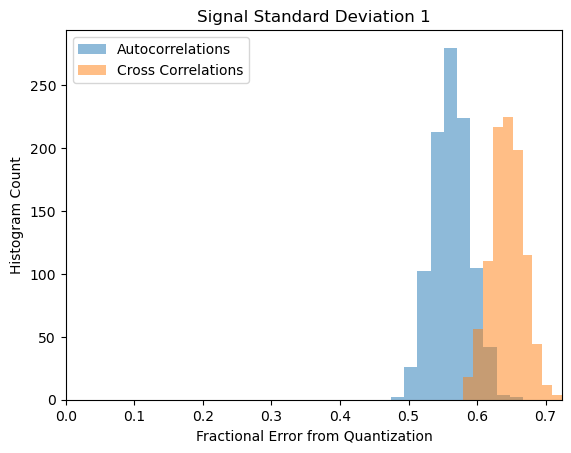

In [35]:
plt.hist(autocorr_fractional_error, alpha=0.5, label="Autocorrelations")
plt.hist(crosscorr_fractional_error, alpha=0.5, label="Cross Correlations")
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.xlim(
    (
        0,
        np.max(
            [
                np.nanmax(autocorr_fractional_error),
                np.nanmax(crosscorr_fractional_error),
            ]
        ),
    )
)
plt.title(f"Signal Standard Deviation {stddev}")
plt.legend()

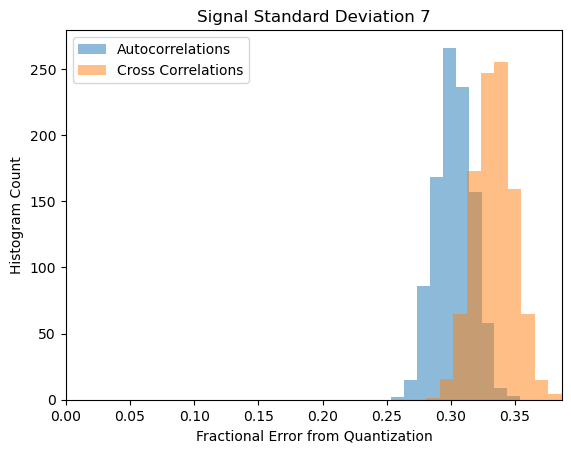

In [39]:
plt.hist(autocorr_fractional_error, alpha=0.5, label="Autocorrelations")
plt.hist(crosscorr_fractional_error, alpha=0.5, label="Cross Correlations")
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.xlim(
    (
        0,
        np.max(
            [
                np.nanmax(autocorr_fractional_error),
                np.nanmax(crosscorr_fractional_error),
            ]
        ),
    )
)
plt.title(f"Signal Standard Deviation {stddev}")
plt.legend()

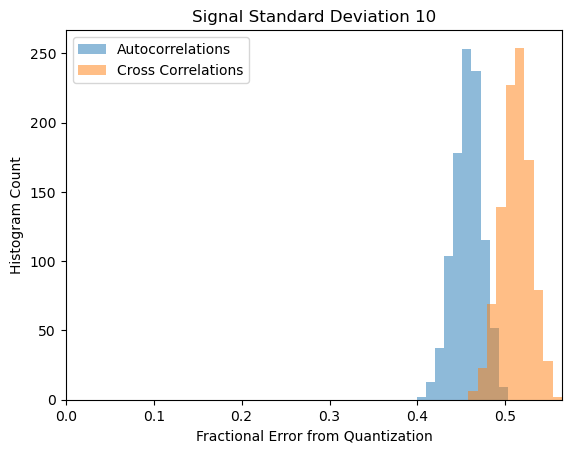

In [49]:
plt.hist(autocorr_fractional_error, alpha=0.5, label="Autocorrelations")
plt.hist(crosscorr_fractional_error, alpha=0.5, label="Cross Correlations")
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.xlim(
    (
        0,
        np.max(
            [
                np.nanmax(autocorr_fractional_error),
                np.nanmax(crosscorr_fractional_error),
            ]
        ),
    )
)
plt.title(f"Signal Standard Deviation {stddev}")
plt.legend()

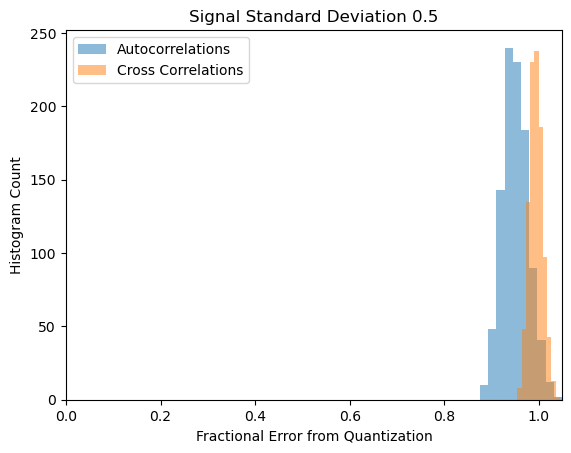

In [51]:
plt.hist(autocorr_fractional_error, alpha=0.5, label="Autocorrelations")
plt.hist(crosscorr_fractional_error, alpha=0.5, label="Cross Correlations")
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.xlim(
    (
        0,
        np.max(
            [
                np.nanmax(autocorr_fractional_error),
                np.nanmax(crosscorr_fractional_error),
            ]
        ),
    )
)
plt.title(f"Signal Standard Deviation {stddev}")
plt.legend()